In [30]:
#RUN THIS ONLY IF YOU HAVE NOT UPLOAD THE ENTIRE REPO TO DRIVE
repo_url="https://github.com/muzgash/community_detection_gnn.git"
repo_name="community_detection_gnn"

In [31]:
#RUN THIS ONLY IF YOU HAVE NOT UPLOAD THE ENTIRE REPO TO DRIVE
!git clone {repo_url}

Cloning into 'community_detection_gnn'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 3), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [32]:
#RUN THIS ONLY IF YOU HAVE NOT UPLOAD THE ENTIRE REPO TO DRIVE
%cd {repo_name}

/root/community_detection_gnn


In [33]:
%ls

community_detection_gnn.ipynb  data/  ENTREGA1.PDF  LICENSE  README.md


In [34]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.13.0+cu116


In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

from sklearn.preprocessing import normalize
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle

## Data loading

In [36]:
A = sp.load_npz("data/colombia_openalex_adj.npz")
X = sp.load_npz("data/colombia_openalex_att.npz")
C = sp.load_npz("data/colombia_openalex_classes.npz")

#remove self loops
A = A.tolil()
A.setdiag(0)
A = A.tocsr()

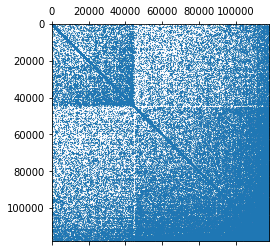

In [37]:
plt.spy(A,markersize=0.1)

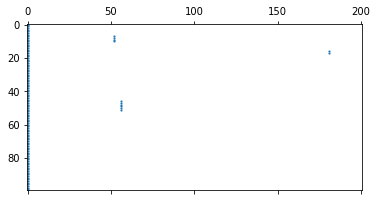

In [38]:
plt.spy(X[800:900,:],markersize=1)

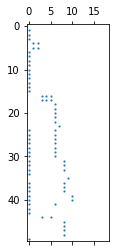

In [39]:
plt.spy(C[:50,:],markersize=1)

### Utility functions

In [40]:
# Functions for normalized mutual information. https://arxiv.org/pdf/1110.2515.pdf

def compare(x, y):
  a = (1 - x).dot(1 - y)
  b = (1 - x).dot(y)
  c = (1 - y).dot(x)
  d = x.dot(y)
  return a, b, c, d

def entropy(w,n):
  if w <= 0:
    return 0
  else:
    return -w*np.log2(w/n)

def vector_entropy(x,y):
  a, b, c, d = compare(x, y)
  n = len(x)
  if entropy(a, n) + entropy(d, n) >= entropy(b, n) + entropy(c, n):
      return entropy(a, n) + entropy(b, n) + entropy(c, n) + entropy(d, n) - entropy(b + d, n) - entropy(a + c, n)
  else:
      return entropy(c + d, n) + entropy(a + b, n)

def unconditional_entropy(X): #matrices
  return sum(entropy(x.sum(), x.shape[-1]) + entropy(x.shape[-1] - x.sum(), x.shape[-1]) for x in X)

def conditional_entropy(X,Y): #matrices
  m, n = X.shape[0], Y.shape[0]
  scores_min=[]
  for i in range(m):
    score_min=1000
    for j in range(n):
      score = vector_entropy(X[i], Y[j])
      if score<score_min:
        score_min=score
    scores_min.append(score_min)
  return sum(scores_min)

def nmi(X,Y):
  if X.shape[1] != Y.shape[1]:
    raise ValueError("Dimensions of X and Y don't match")
  Xue = unconditional_entropy(X)
  Yue = unconditional_entropy(Y)
  XYce = conditional_entropy(X,Y)
  YXce = conditional_entropy(Y,X)
  I = 0.5*(Xue + Yue - XYce - YXce)
  return I/max(Xue, Yue)

In [41]:
#sampling random subgraphs
class Sampler(data_utils.Dataset):
  def __init__(self,A,num_pos=100,num_neg=100):
    self.num_pos = num_pos #number of edges that exists (ones in the adj matrix)
    self.num_neg = num_neg #number of edges that do not exist (zeros in the adj matrix)
    self.A = A
    self.edges = np.transpose(A.nonzero())
    self.num_nodes = A.shape[0]
    self.num_edges = self.edges.shape[0]

  def __len__(self):
    return 2**32

  def __getitem__(self, key):
    np.random.seed(key) #avoinding repeating the sample
    edges_idx = np.random.randint(0, self.num_edges, size=self.num_pos, dtype=np.int64) #random edges from index
    next_edges = self.edges[edges_idx, :]

    generated = False
    while not generated: #getting the nodes without edges
        candidate_ne = np.random.randint(0, self.num_nodes, size=(2*self.num_neg, 2), dtype=np.int64)
        cne1, cne2 = candidate_ne[:, 0], candidate_ne[:, 1]
        to_keep = (1 - self.A[cne1, cne2]).astype(bool).A1 * (cne1 != cne2)
        next_nonedges = candidate_ne[to_keep][:self.num_neg]
        generated = to_keep.sum() >= self.num_neg #when there is a quantity of zeroes ge than the num_neg, stop the while
    return torch.LongTensor(next_edges), torch.LongTensor(next_nonedges)

def collate_fn(batch): #function to merge datasets, needed when you have more than 1 worker
    edges, nonedges = batch[0]
    return (edges, nonedges)

def graph_sampler(A, num_pos=100, num_neg=100, num_workers=2):
    data_source = Sampler(A, num_pos, num_neg)
    return data_utils.DataLoader(data_source, num_workers=num_workers, collate_fn=collate_fn)


In [42]:
def to_torch_sparse_tensor(matrix,cuda=False):
  if sp.issparse(matrix):
    coo = matrix.tocoo()
    indices = torch.LongTensor(np.vstack([coo.row, coo.col]))
    values = torch.FloatTensor(coo.data)
    shape = torch.Size(coo.shape)
    sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)
  elif torch.is_tensor(matrix):
    row, col = matrix.nonzero().t()
    indices = torch.stack([row, col])
    values = matrix[row, col]
    shape = torch.Size(matrix.shape)
    sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)
  if cuda:
    sparse_tensor = sparse_tensor.cuda()
  return sparse_tensor.coalesce()

In [43]:
#Must change the dropout function since I'm working with sparse matrices
def sparse_dropout(x,p=0.5,training=True):
  if isinstance(x, (torch.sparse.FloatTensor, torch.cuda.sparse.FloatTensor)):
    dx = F.dropout(x.values(),p=p,training=training)
    return torch.sparse.FloatTensor(x.indices(),dx,x.size())
  else:
    return F.dropout(x, p=p, training=training)

In [44]:
#evaluation
def eval_nmi(model, X, A, C, threshold=0.5):
  model.eval()
  Z = F.relu(model(X, A))
  Z_pred = Z.cpu().detach().numpy() > threshold
  nmi_ = nmi(Z_pred.T, C.T)
  return nmi_

## Model

In [45]:
class Convolution(nn.Module):
  def __init__(self,input_dim,output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    
    self.weights = nn.Parameter(torch.empty(input_dim,output_dim))
    self.bias = nn.Parameter(torch.empty(output_dim))
    
    nn.init.xavier_uniform_(self.weights) #https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
    nn.init.zeros_(self.bias)
  
  def forward(self, x, adj):
    return adj @ ( x @ self.weights ) + self.bias

class GCN(nn.Module):#https://arxiv.org/pdf/1609.02907.pdf
  def __init__(self,input_dim,hidden_dims,output_dim,dropout=0.5):
    super().__init__()
    self.dropout = dropout
    layer_dims = np.concatenate([hidden_dims,[output_dim]]).astype(np.int32)
    self.layers = nn.ModuleList([Convolution(input_dim,layer_dims[0])])
    for i in range(len(layer_dims)-1): #last one refers to the output
      self.layers.append(Convolution(layer_dims[i],layer_dims[i+1]))
  
  def forward(self,x,A):
    for i,layer in enumerate(self.layers):
      if self.dropout != 0:
        x = sparse_dropout(x,p=self.dropout,training=self.training)
      x = layer(x,A)
      if i != len(self.layers)-1:
        x=F.relu(x)
    return x

#verify if I'm counting self-loops
#Code the imbalanced likelihood
def bernoulli_poisson_loss(Z,A,Ne,Npe):
  edge_prob = -np.log(1-Ne/Npe) #number of edges/number of possible edges
  f,t = A.nonzero() #indexes of edges on each dimension (from,to)
  FuFv = torch.sum(Z[f]*Z[t],dim=1)
  loss_edges = -torch.sum(torch.log(-torch.expm1(-edge_prob-FuFv)))

  #adding the contribution of all nodes
  #and substracting the contribution of connected nodes
  # the non edges contribution is obtained
  total = torch.sum(Z,dim=0,keepdim=True).t()
  loss_nonedges = torch.sum(Z@total)-torch.sum(FuFv)

  return loss_edges/Ne+loss_nonedges/Nne

## Parameters

In [46]:
Nn = A.shape[0] #number of nodes
Ne = A.nnz #number of edges
Npe = (Nn**2-Nn) #number of possible edges
Nne = Npe - Ne#number of non edges

hidden_sizes = [128,64]
dropout = 0.5
lr = 1e-3
max_epochs = 500
display_step = 50
batch_size = 100
threshold = 0.5

In [47]:
Aa = to_torch_sparse_tensor(A)
Xx = to_torch_sparse_tensor(X)
Cc = C.toarray().astype(np.float32)

In [48]:
sampler = graph_sampler(A,batch_size,batch_size,4)
model = GCN(X.shape[1],hidden_sizes,C.shape[1],dropout=dropout)
opt = torch.optim.Adam(model.parameters(),lr=lr)

## Training

In [49]:
loss_list=[]
nmi_list=[]
for epoch, batch in enumerate(sampler):
  if epoch > max_epochs:
        break
  if epoch%display_step == 0:
    with torch.no_grad():
      model.eval()
      Z_pred = F.relu(model(Xx,Aa))
      val_loss = bernoulli_poisson_loss(Z_pred,A,Ne,Npe)
      val_nmi = eval_nmi(model,Xx,Aa,Cc)
      loss_list.append(val_loss)
      nmi_list.append(val_nmi)
      print('Epoch: {}, loss: {}, nmi: {}'.format(epoch,val_loss,val_nmi))
  model.train()
  opt.zero_grad()
  Z_pred = F.relu(model(Xx,Aa))
  loss = bernoulli_poisson_loss(Z_pred,A,Ne,Npe)
  loss.backward()
  opt.step()

Epoch: 0, loss: 2.0355783926954886e+22, nmi: 0.597835802938488
Epoch: 50, loss: 1.8245131429191057e+22, nmi: 0.5612376441159823
Epoch: 100, loss: 1.756522411934684e+22, nmi: 0.6035068798208338
Epoch: 150, loss: 1.6111562364723353e+22, nmi: 0.650830224424255
Epoch: 200, loss: 1.4416321896588178e+22, nmi: 0.7021493539297499
Epoch: 250, loss: 1.2592001507733124e+22, nmi: 0.7461481542383144
Epoch: 300, loss: 9.963250405236965e+21, nmi: 0.7925030134088599
Epoch: 350, loss: 7.668693416689462e+21, nmi: 0.839672993081538
Epoch: 400, loss: 5.203588487953158e+21, nmi: 0.8855421074466518
Epoch: 450, loss: 3.4133524669779505e+21, nmi: 0.9230038998710477
Epoch: 500, loss: 2.254613578289936e+21, nmi: 0.9576935982945242


### Evaluation

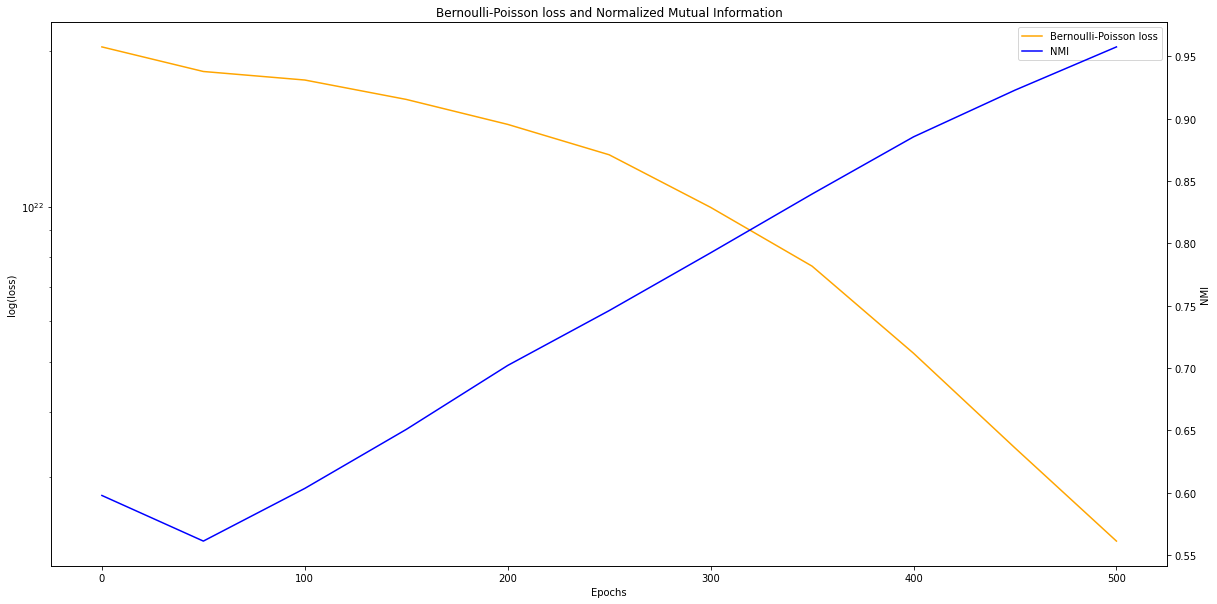

In [59]:
x=range(0,epoch,display_step)
fig,ax1=plt.subplots(figsize=(20,10))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("log(loss)")
l1=ax1.semilogy(x,loss_list,'orange',label="Bernoulli-Poisson loss")
ax2 = ax1.twinx()
ax2.set_ylabel("NMI")
l2=ax2.plot(x,nmi_list,'b',label="NMI")
plt.title("Bernoulli-Poisson loss and Normalized Mutual Information")
lines=l1+l2
labs = [l.get_label() for l in lines]
ax1.legend(lines,labs)
plt.show()

In [51]:
*model.eval()
Z = F.relu(model(Xx, Aa))
Z_pred = Z.cpu().detach().numpy() > threshold
print("Final NMI: {}".format(eval_nmi(model,Xx,Aa,Cc)))

Final NMI: 0.9582675363536782
